# Description of task
- This is a classification task. 
- In the given data, train.tsv and test.tsv are used for training and testing respectively. The training data is tab sepearted with a label and tokenized sequential data. For example, the tokenized data wr4pi, pze1d, etc.. are actually words of a text document. 
- Each token is a length of 5 (alpha-numeric letters).
- Build your model in this jupyter notebook and submit your prediction results as a csv file along with this notebook
- Try to use PEP 8 style guide.

## Prepare the data. (0pts)

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
import csv
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from nltk import ngrams, FreqDist
from matplotlib import pyplot,rcParams
rcParams.update({'figure.autolayout': True})

#if running on colab, replace the values with the links of the uploaded train.tsv and test.tsv
trainTsvPath = "/content/train.tsv"
testTsvPath = "/content/test.tsv"

with open(trainTsvPath, "r", encoding="utf-8", newline='') as trainTsvFile:
  tsvTrainReader = csv.reader(trainTsvFile, delimiter='\t')
  X = []
  Y = []
#the list of tokens is needed for eda
  tokens = []
  for t in tsvTrainReader:
    tokenListPerLine = t[1].split(",")
#join the comma-separated tokens for future use by tfidf vectorizer
    X.append(" ".join(tokenListPerLine))
    Y.append(t[0])
    tokens += tokenListPerLine
#change separator to "," as test.tsv does not have tabs in it
  with open(testTsvPath, "r", encoding="utf-8", newline='') as testTsvFile:
    csvTestReader = csv.reader(testTsvFile)
    XTest = []
    for c in csvTestReader:
      XTest.append(" ".join(c))
      tokens += c
    


## EDA (15pts)

<Figure size 432x288 with 0 Axes>

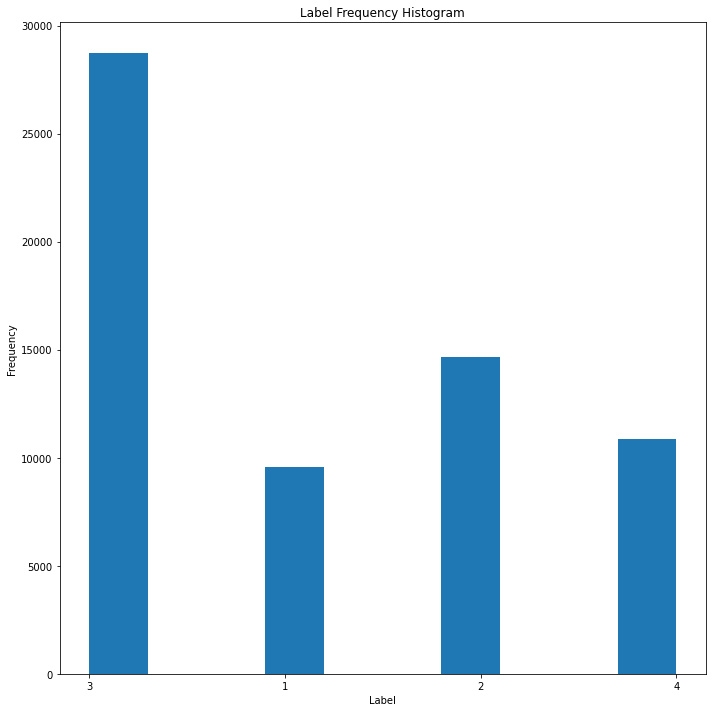

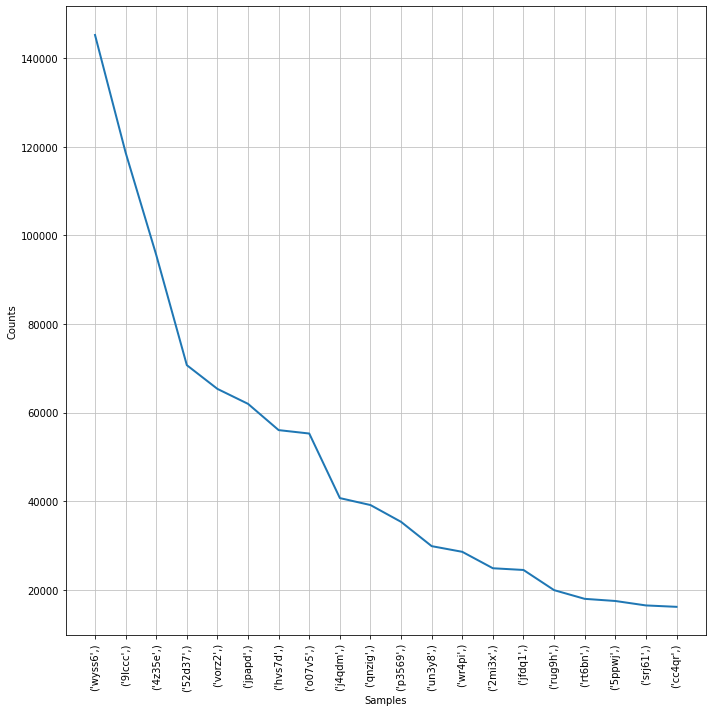

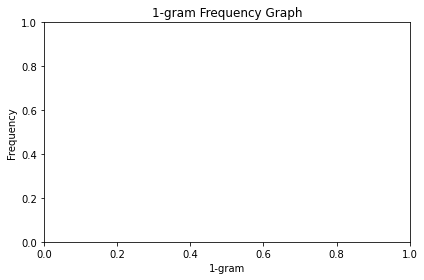

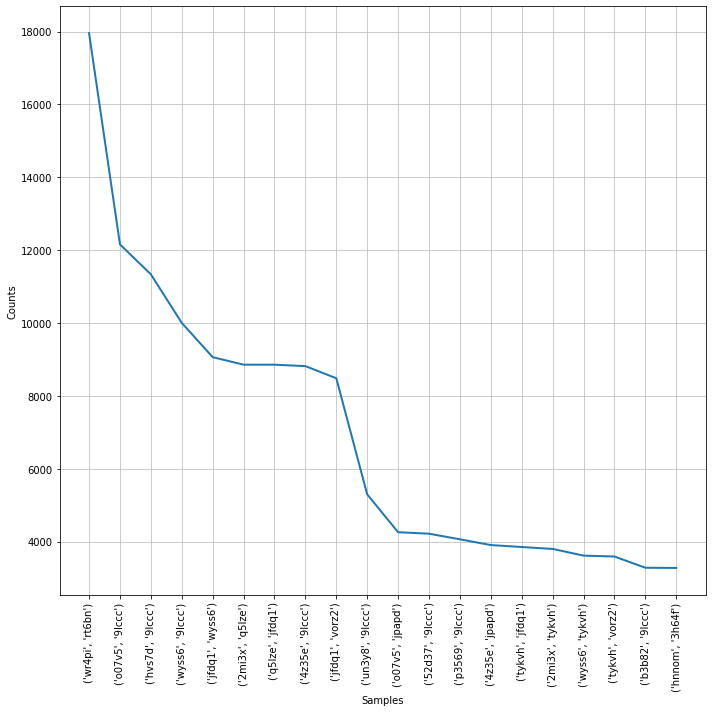

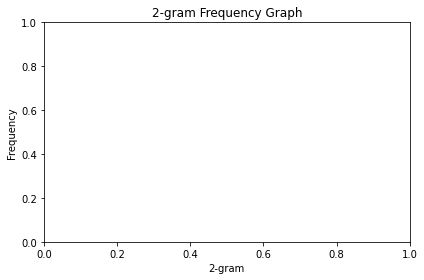

In [6]:
maxN = 2
plotFreqSize = 20
plotWidth = 10
plotHeight = 10

pyplot.tight_layout()
labelFreqPlot =pyplot.figure(figsize=(plotWidth, plotHeight))
#check whether we get a binary classification or multiclass classification problem.
#also for checking whether the classes are balanced.
pyplot.hist(Y)
pyplot.gca().set(title='Label Frequency Histogram', xlabel='Label', ylabel='Frequency');
pyplot.show()
labelFreqPlot.savefig("labelFreqPlot.png")

#check whether some words are repeated such that tfidf vectors would be a good option for representing the text data
#check whether some n-grams are repeated sufficient times such that including them as features in vector representations would be considered a good idea

for n in range(1,maxN+1):
  ngramFreqPlot = pyplot.figure(figsize=(plotWidth, plotHeight))
  ngramFreq = FreqDist(ngrams(tokens,n))
  ngramFreq.plot(plotFreqSize)
  pyplot.gca().set(title=str(n) +'-gram Frequency Graph', xlabel=str(n)+'-gram', ylabel='Frequency');
  pyplot.show()
  ngramFreqPlot.savefig(str(n)+"gramFreqPlot.png")

## Split labelled data into training and validation data set. Then build your model from training data and evaluate your prediction on validation data using suitable metric. (15 pts)

In [5]:
split = 0.2
seed = 42

XTrain, XVal, YTrain, YVal = train_test_split(X, Y, test_size=split, random_state=seed)
vectorizer = TfidfVectorizer(ngram_range=(1, maxN))
vectorizer.fit(XTrain)
XTrainVec = vectorizer.transform(XTrain)
XValVec = vectorizer.transform(XVal)
classifier = KNeighborsClassifier()
classifier.fit(XTrainVec, YTrain)
YPred = classifier.predict(XValVec)
print(classification_report(YVal, YPred))

              precision    recall  f1-score   support

           1       0.89      0.86      0.87      1882
           2       0.93      0.97      0.95      3007
           3       0.90      0.93      0.92      5749
           4       0.86      0.74      0.80      2122

    accuracy                           0.90     12760
   macro avg       0.90      0.88      0.88     12760
weighted avg       0.90      0.90      0.90     12760



## Build a prediction model from training data and predict on testing data. (60pts) 

In [ ]:
import multiprocessing

predictTsvPath = "predict.tsv"
n_cpus = multiprocessing.cpu_count()

#hyper-parameter tuning and cross-validation
params =  {
    'n_neighbors': (1,21, 2),
    'leaf_size': (20,40,1),
    'p': (1,2),
    'weights': ('uniform', 'distance')  }
gridObj = GridSearchCV(KNeighborsClassifier(), params, cv=int(1/split),
                           scoring='f1_macro', n_jobs=n_cpus-1, verbose=5)
vectorizer = TfidfVectorizer(ngram_range=(1, maxN))
vectorizer.fit(X)
XVec = vectorizer.transform(X)
XTestVec= vectorizer.transform(XTest)
gridObj.fit(XVec, Y)
means = gridObj.cv_results_['mean_test_score']
print ("cross validation results")
for mean, params in zip(means, gridObj.cv_results_['params']):
    print("%0.3f for %r"
              % (mean, params))

#train a knn classifier with the best parameters from grid search and cross-validation    
classifier = KNeighborsClassifier()
classifier.set_params(**gridObj.best_params_)
classifier.fit(XVec, Y)
with open(predictTsvPath, 'w', newline='') as predictTsvFile:
    predictWriter = csv.writer(predictTsvFile,  delimiter='\t')
    for y,x in zip(classifier.predict(XTestVec), XTest):
        predictWriter.writerow([y,",".join(x.split())])


Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5] END leaf_size=20, n_neighbors=1, p=1, weights=uniform;, score=0.612 total time= 5.8min
[CV 2/5] END leaf_size=20, n_neighbors=1, p=1, weights=uniform;, score=0.644 total time= 5.8min
[CV 3/5] END leaf_size=20, n_neighbors=1, p=1, weights=uniform;, score=0.593 total time= 5.7min
[CV 4/5] END leaf_size=20, n_neighbors=1, p=1, weights=uniform;, score=0.613 total time= 5.8min
[CV 5/5] END leaf_size=20, n_neighbors=1, p=1, weights=uniform;, score=0.616 total time= 5.7min
[CV 1/5] END leaf_size=20, n_neighbors=1, p=1, weights=distance;, score=0.612 total time= 5.7min
[CV 2/5] END leaf_size=20, n_neighbors=1, p=1, weights=distance;, score=0.644 total time= 6.2min
[CV 3/5] END leaf_size=20, n_neighbors=1, p=1, weights=distance;, score=0.593 total time= 6.7min
[CV 4/5] END leaf_size=20, n_neighbors=1, p=1, weights=distance;, score=0.613 total time= 5.8min
[CV 5/5] END leaf_size=20, n_neighbors=1, p=1, weights=distance;, scor

## Comments on how to improve your result (or prediction model). (10pts)

Assuming no changes to the tfidf vector I am using for representing the text data, I can try a few other classification algorithm besides knn and select the one that works best in the cross-validation. 

Another alternative would be creating skipgram/CBOW embeddings  with the text data provided and training neural networks on the embeddings. 